In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch

# 读取CSV数据
data = pd.read_csv('../Dataset/BuildingEnergyLoad/BuildingConsumptionLoad.csv')

# 处理时间序列
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 归一化数据
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Total_Power(kWh)'].values.reshape(-1, 1))

# 创建输入序列和目标序列
def create_dataset(dataset, look_back=24):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24  # 使用过去24小时的数据来预测下一小时
X, Y = create_dataset(scaled_data, look_back)

# 划分训练和测试集
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# 转换为PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
Y_test = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(-1)

# 将数据移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

In [11]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# 创建模型实例并移动到GPU
model = LSTM().to(device)

In [12]:
import torch.optim as optim

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

for i in range(epochs):
    for seq, labels in zip(X_train, Y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    if i%2 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   0 loss: 0.00149598


In [4]:
torch.save(model.state_dict(), './saved_models/lstm_model.pth')

Test Score: 43.86876130668974 RMSE


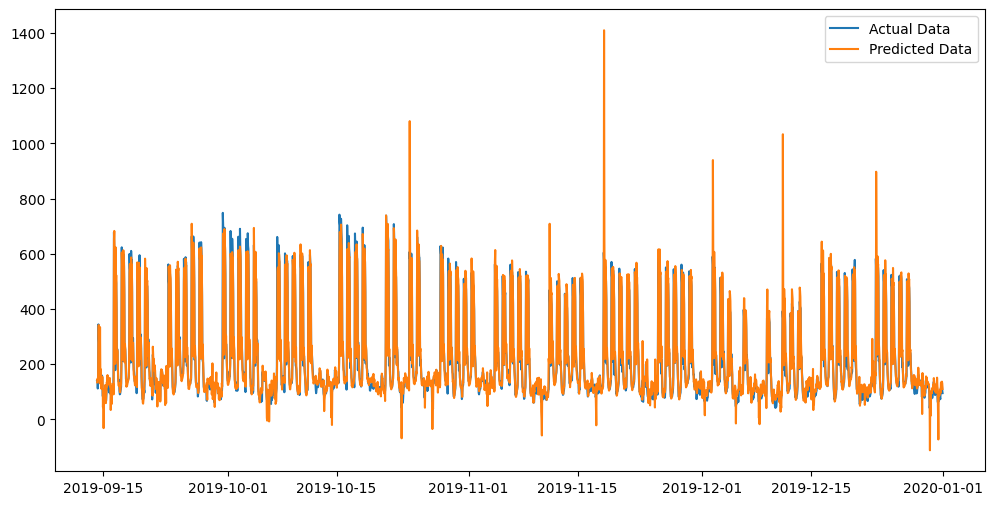

In [9]:
model = LSTM().to(device)
model.load_state_dict(torch.load('./saved_models/lstm_model.pth'))
model.eval()

# 预测测试集数据
with torch.no_grad():
    predictions = []
    for seq in X_test:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        predictions.append(model(seq).item())

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(Y_test.cpu().numpy().reshape(-1, 1))

# 计算均方误差
test_score = np.sqrt(np.mean((predictions - actuals) ** 2))
print(f'Test Score: {test_score} RMSE')

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predictions):], actuals, label='Actual Data')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted Data')
plt.legend()
plt.show()

In [8]:
# 预测下一小时的数据
model.eval()
with torch.no_grad():
    last_24_hours = scaled_data[-look_back:]  # 取过去24小时的数据
    last_24_hours = torch.tensor(last_24_hours, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                    torch.zeros(1, 1, model.hidden_layer_size).to(device))
    
    next_hour_prediction = model(last_24_hours).item()
    next_hour_prediction = scaler.inverse_transform(np.array(next_hour_prediction).reshape(-1, 1))
    print(f'Next hour prediction: {next_hour_prediction[0][0]} kWh')

# 预测下一天的数据
predictions = []
with torch.no_grad():
    for _ in range(24):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        
        next_hour_prediction = model(last_24_hours).item()
        predictions.append(next_hour_prediction)
        
        next_hour = torch.tensor([[next_hour_prediction]], dtype=torch.float32).to(device)
        last_24_hours = torch.cat((last_24_hours[:, 1:, :], next_hour.unsqueeze(0)), dim=1)
    
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    print(f'Next day predictions: {predictions.flatten()}')

# 绘制下一天的预测结果
plt.figure(figsize=(12, 6))
plt.plot(range(24), predictions, label='Predicted Data')
plt.legend()
plt.show()

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 24